In [1]:
!pip install apache-beam pandas matplotlib


Airbnb_Open_Data.csv  sample_data


In [22]:
import apache_beam as beam
from apache_beam.options.pipeline_options import PipelineOptions
import csv
from io import StringIO
import pandas as pd
import ast


In [35]:
# --- 2. Define cleaning and preprocessing function ---
def clean_airbnb_record(line):
    if not line.strip():
        return None  # skip empty lines
    try:
        reader = csv.reader(StringIO(line))
        row = next(reader)

        # Skip rows with missing columns
        if len(row) < 19:
            return None

        # --- Extract columns safely ---
        neighbourhood_group = row[5].strip().title() if len(row) > 5 else "Unknown"
        room_type = row[13].strip().title() if len(row) > 13 else "Unknown"
        price_str = row[15].replace('$', '').replace(',', '').strip() if len(row) > 15 else "0"
        service_fee_str = row[16].replace('$', '').replace(',', '').strip() if len(row) > 16 else "0"
        reviews_str = row[18].strip() if len(row) > 18 else "0"

        # --- Convert to numeric ---
        price = float(price_str) if price_str else 0.0
        service_fee = float(service_fee_str) if service_fee_str else 0.0
        reviews = float(reviews_str) if reviews_str else 0.0

        # --- Filter invalid or unrealistic data ---
        if not neighbourhood_group or not room_type:
            return None
        if price <= 10 or price > 2000:
            return None
        if service_fee < 0 or service_fee > 500:
            service_fee = 0.0
        if reviews < 0:
            reviews = 0.0

        # --- Derived metrics ---
        total_cost = price + service_fee

        # --- Normalization (min-max scaling) ---
        price_norm = (price - 10) / (2000 - 10)
        reviews_norm = min(reviews / 50.0, 1.0)  # cap at 50 reviews

        return {
            'neighbourhood_group': neighbourhood_group,
            'room_type': room_type,
            'price': round(price, 2),
            'service_fee': round(service_fee, 2),
            'total_cost': round(total_cost, 2),
            'reviews': round(reviews, 1),
            'price_norm': round(price_norm, 4),
            'reviews_norm': round(reviews_norm, 4)
        }

    except Exception:
        return None




In [36]:
options = PipelineOptions(flags=[], save_main_session=True)

# --- 4. Define and run the Beam pipeline ---
with beam.Pipeline(options=options) as p:
    # Step 1: Read and clean data
    cleaned = (
        p
        | "Read Airbnb CSV" >> beam.io.ReadFromText("Airbnb_Open_Data.csv", skip_header_lines=1)
        | "Clean Records" >> beam.Map(clean_airbnb_record)
        | "Filter Valid" >> beam.Filter(lambda x: x is not None)
    )

    # Step 2: Average price by (neighbourhood_group, room_type)
    avg_price = (
        cleaned
        | "Key by Neighbourhood & Room" >> beam.Map(lambda r: ((r["neighbourhood_group"], r["room_type"]), r["price"]))
        | "Combine Avg Price" >> beam.CombinePerKey(lambda vals: sum(list(vals)) / len(list(vals)))
    )

    # Step 3: Average total cost per neighbourhood group
    avg_total_cost = (
        cleaned
        | "Key by Neighbourhood Group" >> beam.Map(lambda r: (r["neighbourhood_group"], r["total_cost"]))
        | "Combine Avg Total Cost" >> beam.CombinePerKey(lambda vals: sum(list(vals)) / len(list(vals)))
    )

    # Step 4: Classify affordability using avg price
    classified = (
        avg_price
        | "Classify Affordability" >> beam.Map(lambda kv: {
            "neighbourhood_group": kv[0][0],
            "room_type": kv[0][1],
            "avg_price": round(kv[1], 2),
            "affordability": "Luxury" if kv[1] > 200 else "Mid-range" if kv[1] >= 80 else "Budget"
        })
    )

    # Step 5: Write both outputs to separate files
    classified | "Write Price Summary" >> beam.io.WriteToText(
        "./output/airbnb_price_summary",
        file_name_suffix=".csv",
        shard_name_template=""
    )

    avg_total_cost | "Write Total Cost Summary" >> beam.io.WriteToText(
        "./output/airbnb_totalcost_summary",
        file_name_suffix=".csv",
        shard_name_template=""
    )


In [37]:
# --- 5. Verify file creation ---
!ls output


airbnb_price_summary.csv  airbnb_totalcost_summary.csv


In [38]:
# --- 6. Preview the results ---
print("Average Price Summary:")
!head output/airbnb_price_summary.csv

print("\nAverage Total Cost Summary:")
!head output/airbnb_totalcost_summary.csv


Average Price Summary:
{'neighbourhood_group': 'Brooklyn', 'room_type': 'Private Room', 'avg_price': 781.5, 'affordability': 'Luxury'}
{'neighbourhood_group': 'Manhattan', 'room_type': 'Entire Home/Apt', 'avg_price': 691.29, 'affordability': 'Luxury'}
{'neighbourhood_group': 'Manhattan', 'room_type': 'Private Room', 'avg_price': 632.01, 'affordability': 'Luxury'}
{'neighbourhood_group': 'Brooklyn', 'room_type': 'Entire Home/Apt', 'avg_price': 620.3, 'affordability': 'Luxury'}
{'neighbourhood_group': 'Brookln', 'room_type': 'Private Room', 'avg_price': 580.0, 'affordability': 'Luxury'}
{'neighbourhood_group': 'Manhatan', 'room_type': 'Private Room', 'avg_price': 460.0, 'affordability': 'Luxury'}
{'neighbourhood_group': 'Manhattan', 'room_type': 'Shared Room', 'avg_price': 577.69, 'affordability': 'Luxury'}
{'neighbourhood_group': 'Queens', 'room_type': 'Private Room', 'avg_price': 619.47, 'affordability': 'Luxury'}
{'neighbourhood_group': 'Staten Island', 'room_type': 'Private Room', 'a

Price Summary:


,neighbourhood_group,room_type,avg_price,affordability
0,Brooklyn,Private Room,781.50,Luxury
1,Manhattan,Entire Home/Apt,691.29,Luxury
2,Manhattan,Private Room,632.01,Luxury
3,Brooklyn,Entire Home/Apt,620.30,Luxury
4,Brookln,Private Room,580.00,Luxury


Total Cost Summary:


,neighbourhood_group,avg_total_cost
0,Brooklyn,601.438777
1,Manhattan,872.989204
2,Brookln,696.000000
3,Manhatan,460.000000
4,Queens,779.089677


<Axes: title={'center': 'Average Total Cost (Price + Fee) per Neighbourhood'}, xlabel='neighbourhood_group'>

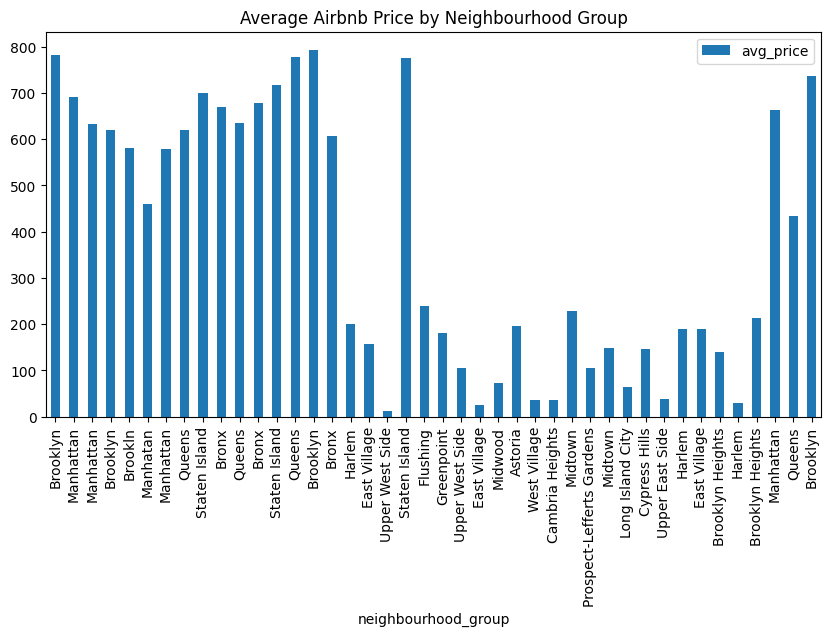

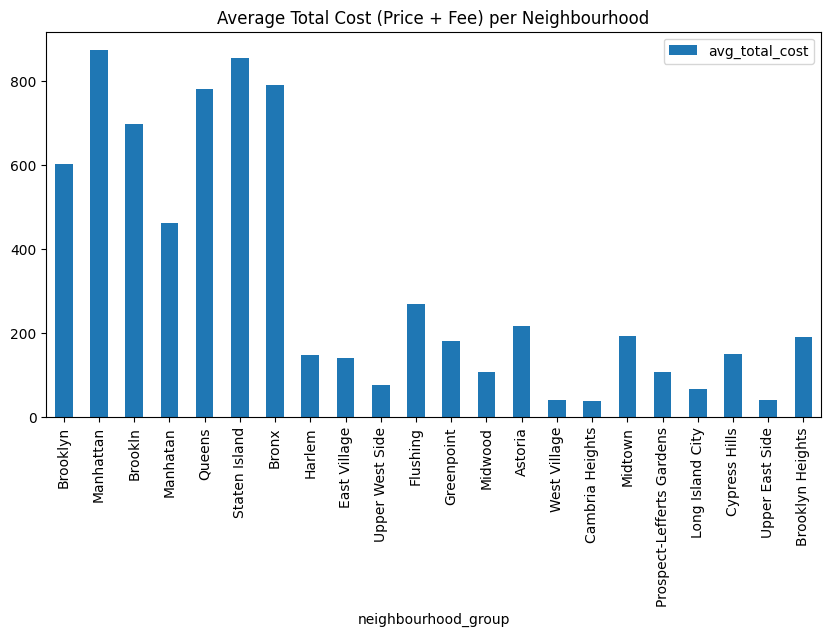

In [40]:
# --- 7. Load both into Pandas for analysis ---
data_price = []
with open("output/airbnb_price_summary.csv", "r") as f:
    for line in f:
        # Safely evaluate the string as a Python dictionary
        data_price.append(ast.literal_eval(line.strip()))

df_price = pd.DataFrame(data_price)

data_cost = []
with open("output/airbnb_totalcost_summary.csv", "r") as f:
    for line in f:
        # Safely evaluate the string as a Python tuple
        data_cost.append(ast.literal_eval(line.strip()))

df_cost = pd.DataFrame(data_cost, columns=['neighbourhood_group', 'avg_total_cost'])


print("Price Summary:")
display(df_price.head())

print("Total Cost Summary:")
display(df_cost.head())

# Optional Visualization
df_price.plot(kind="bar", x="neighbourhood_group", y="avg_price", figsize=(10,5),
              title="Average Airbnb Price by Neighbourhood Group")
df_cost.plot(kind="bar", x="neighbourhood_group", y="avg_total_cost", figsize=(10,5),
             title="Average Total Cost (Price + Fee) per Neighbourhood")